
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW-Q : Overtopping estimation of historical nearshore storms at 3 locations

inputs required: 
  * Historical DWTs
  * MU - TAU intradaily hidrographs time series
  * Historical water levels

in this notebook:
  * HyCReWW-Q overtopping estimation of historical events
  

**HyCReWW - Q** provides wave-driven overtopping estimations along coral reef-lined shorelines under a wide range of fringing reef morphologies and offshore forcing characteristics. The metamodel is based on two models: (a) a full factorial design of recent XBeach Non-Hydrostatic simulations under different reef configurations and offshore wave and water level conditions (Pearson et al, 2017); and (b) Radial Basis Functions (RBFs) for approximating the non-linear function of overtopping for the set of multivariate parameters:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Runup = RBF($\eta_0$, $H_0$, ${H_0/L_0}$, $\beta_f$,$W_{reef}$, $\beta_b$, $c_f$, $Z_b$ );&nbsp;&nbsp;&nbsp;&nbsp;</center>

Where, the hydrodynamic variables defined are offshore water level ($\eta_0$), significant wave height ($H_0$), and wave steepness (${H_0/L_0}$); the reef morphologic parameters include fore reef slope ($\beta_f$), reef flat width ($W_reef$), beach slope ($\beta_b$), seabed roughness ($c_f$) and beach crest elevation ($Z_b$). ${L_0}$ is the deep water wave length $L_0=gT_p^2/2pi$, and $T_p$ is the peak period.

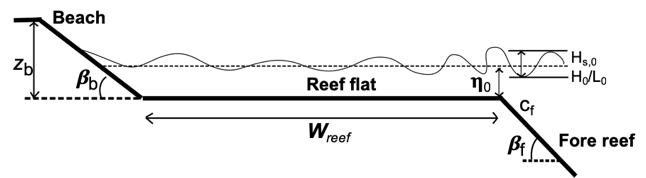

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import linregress
from datetime import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize

from teslakit.estela import Predictor

from teslakit.util.time_operations import npdt64todatetime, fast_reindex_hourly, repair_times_hourly, add_max_storms_mask
   



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


# --------------------------------------
# Load historical DWTs
pred = Predictor(db.paths.site.ESTELA.pred_slp)

pred.Load() # Load predictor PCA, KMA
xds_KMA = pred.KMA


# --------------------------------------
# N, S, E profiles
pN = 35 #29 (36,22)
pS = 13 #7  (13,1)
pE = 18 #17 (21,14)


# --------------------------------------
# load Hycreww RBF coefficients and sim. variables min. and max.

# reef characteristics
xds = xr.open_dataset(op.join(p_data, 'inputs_Kwajalein','datos_perfiles_albaR','data_profiles.nc'))
reef_N = xds.sel(profile = pN )
reef_S = xds.sel(profile = pS)
reef_E = xds.sel(profile = pE)

# Hycreww limits and coefficients
var_lims, rbf_coeffs = db.Load_HYCREWW_Q()


# --------------------------------------
# Load historical TWL

hist_TWL = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_TWL.nc')


# --------------------------------------
# MU - TAU intradaily hidrographs time series

xds_mutau_N = xr.open_dataset(op.join(p_data, 'sites', 'KWAJALEIN', 'ESTELA', 'hydrographs', 'MuTau_N.nc'))
xds_mutau_S = xr.open_dataset(op.join(p_data, 'sites', 'KWAJALEIN', 'ESTELA', 'hydrographs', 'MuTau_S.nc'))
xds_mutau_E = xr.open_dataset(op.join(p_data, 'sites', 'KWAJALEIN', 'ESTELA', 'hydrographs', 'MuTau_E.nc'))

xds_mutau_N = xds_mutau_N.rename(time_runup_max='time')
xds_mutau_S = xds_mutau_S.rename(time_runup_max='time')
xds_mutau_E = xds_mutau_E.rename(time_runup_max='time')

print(xds_mutau_N)


<xarray.Dataset>
Dimensions:    (time: 3365)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-24T15:00:00 ... 2016-12-28T18:00:00
Data variables:
    MU         (time) float64 ...
    MU2        (time) float64 ...
    TAU        (time) float64 ...
    Hs         (time) float64 ...
    Tp         (time) float64 ...
    Dir        (time) float64 ...
    Runup_max  (time) float64 ...
    WT         (time) int64 ...


# Storms to hourly data

In [3]:
def Intradaily_Hydrograph(xds_mutau):
    '''
    Calculates intradaily hydrograph (hourly) from a time series of storms.
    storms waves data (hs, tp, dir) and TCs data (mu, tau, ss) is needed.

    xds_wvs (waves aggregated):
        xarray.Dataset (time,), Hs, Tp, Dir

    xds_tcs (TCs):
        xarray.Dataset (time,), mu, tau, ss

    returns xarray.Dataset (time,), Hs, Tp, Dir, SS  (hourly)
    '''

    # input data (storms aggregated waves)
    Hs = xds_mutau.Hs.values[:]
    Tp = xds_mutau.Tp.values[:]
    Dir = xds_mutau.Dir.values[:]
    ts = xds_mutau.time.values[:]

    
    # TODO: this should not be needed
    if isinstance(ts[0], np.datetime64):
        ts = [npdt64todatetime(x) for x in ts]
        

    # input data (storms TCs)
    tau = xds_mutau.TAU.values[:]  # storm max. instant (0-1)
    mu = xds_mutau.MU.values[:]
    #ss = xds_tcs.ss.values[:]

        
    # storm durations
    s_dur_h = np.array([x.total_seconds()/3600 for x in np.diff(ts)])  # hours
    s_cs_h = np.cumsum(s_dur_h)  # hours since time start
    s_cs_h = np.insert(s_cs_h,0,0)
       
    # storm tau max (hourly)
    tau_h = np.floor(s_cs_h[:-1] + s_dur_h * tau[:-1])

    
    # aux function
    def CalcHydro(vv, vt, tt, mt):
        '''
        Calculate variable hourly hydrograph.
        vv - var value at max.
        vt - var time (hours since start, at hydrograph extremes)
        tt - tau max time (hours since start).
        mt - mu value
        '''
        
        # var value at hydrographs extremes
        vv_extr = vv * np.power(2*mt-1, 2)
        
        
        # make it continuous
        vv_extr_cont = (np.roll(vv_extr,1) + vv_extr) / 2
        vv_extr_cont[0] = vv_extr_cont[1]
        vv_extr_cont[-1] = vv_extr_cont[-2]
        
        
        # join hydrograph max. and extremes variable data
        vt_full = np.concatenate([vt, tt])  # concatenate times (used for sorting)
        vv_full = np.concatenate([vv_extr_cont, vv])        

        
        # sort data
        ix = np.argsort(vt_full)
        vt_sf = vt_full[ix]
        vv_sf = vv_full[ix]
        
            
        # interpolate to fill all hours
        h_times = np.arange(vt_sf[0], vt_sf[-1] + 1, 1)
        
        h_values = np.interp(h_times, vt_sf, vv_sf)

        # fix times
        h_times = h_times.astype(int)
        

        return h_values, h_times
    

    # hydrograph variables: hs and ss
    hourly_Hs, hourly_times = CalcHydro(Hs, s_cs_h, tau_h, mu)        
    #hourly_ss, _ = CalcHydro(ss, s_cs_h, tau_h, mu)
    
    
    # resample waves data to hourly (pad Tp and Dir)
    xds_wvs_h = fast_reindex_hourly(xds_mutau)
            
    # select wave variables
    xds_wvs_h = xds_wvs_h[['Hs','Tp','Dir']]

    # add Hs and SS 
    xds_wvs_h['Hs'] =(('time',), hourly_Hs)
    #xds_wvs_h['SS'] =(('time',), hourly_ss)

    return xds_wvs_h



In [4]:

# calculate intradaily hourly hydrographs for simulated storms
WAVES_N = Intradaily_Hydrograph(xds_mutau_N)
WAVES_S = Intradaily_Hydrograph(xds_mutau_S)
WAVES_E = Intradaily_Hydrograph(xds_mutau_E)
print(WAVES_N)
print()

# repair times: remove duplicates (if any)
WAVES_N = repair_times_hourly(WAVES_N)
WAVES_S = repair_times_hourly(WAVES_S)
WAVES_E = repair_times_hourly(WAVES_E)
print(WAVES_N)
print()

# add mask for max_storms times
#WVS_h = add_max_storms_mask(WVS_h, xds_mutau_N.Runup_max.values, name_mask='max_storms')
#print(WVS_h)
#print()

   

<xarray.Dataset>
Dimensions:  (time: 332476)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-24T15:00:00 ... 2016-12-28T18:00:00
Data variables:
    Hs       (time) float64 0.02464 0.03953 0.05443 ... 0.02564 0.01979 0.01394
    Tp       (time) float64 3.545 3.545 3.545 3.545 ... 3.924 3.924 3.924 3.805
    Dir      (time) float64 27.24 27.24 27.24 27.24 ... 346.6 346.6 346.6 23.99

<xarray.Dataset>
Dimensions:  (time: 332476)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-24T15:00:00 ... 2016-12-28T18:00:00
Data variables:
    Hs       (time) float64 0.02464 0.03953 0.05443 ... 0.02564 0.01979 0.01394
    Tp       (time) float64 3.545 3.545 3.545 3.545 ... 3.924 3.924 3.924 3.805
    Dir      (time) float64 27.24 27.24 27.24 27.24 ... 346.6 346.6 346.6 23.99



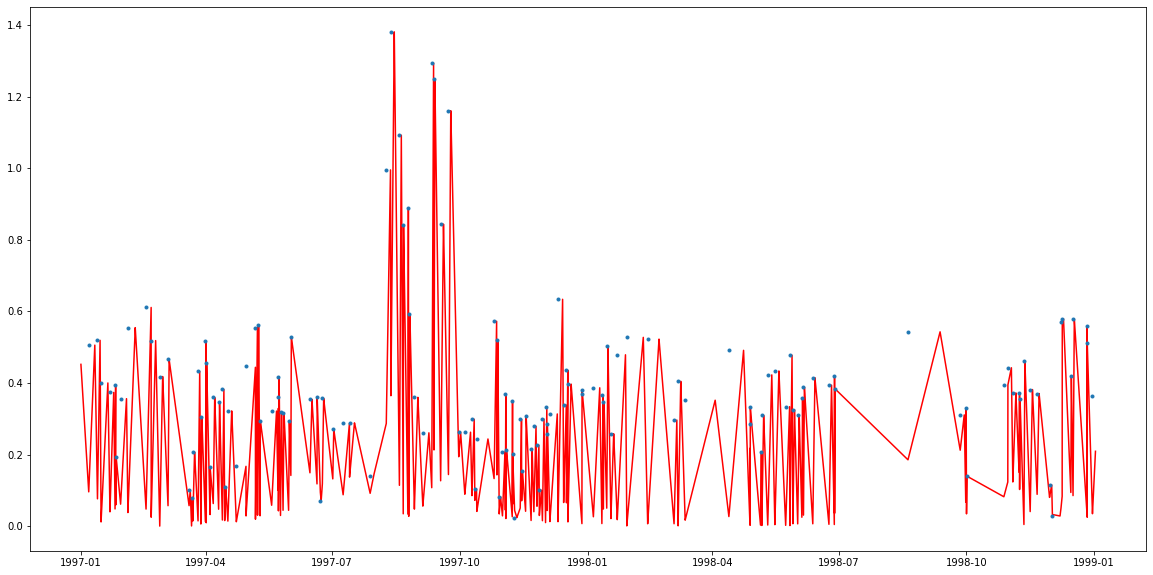

In [5]:
plt.figure(figsize=(20,10))

time_ini = '1997-01-01'
time_fin = '1999-01-01' 

kk_h = WAVES_N.sel(time=slice(time_ini, time_fin))
kk_storms = xds_mutau_N.sel(time=slice(time_ini, time_fin))

plt.plot(kk_h.time, kk_h.Hs, 'r')
plt.plot(kk_storms.time, kk_storms.Hs, '.')




## Hycreww RBF Interpolation

##### Set parameters for Hycreww: TWL, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf

In [7]:

dset_N = xr.Dataset(
            {   'hs':(('time'), WAVES_N.Hs.values),
                'tp':(('time'), WAVES_N.Tp.values),
                'bslope':(('time'), np.ones(len(WAVES_N.time),)*reef_N['Beach Slope'].values),
                'rslope':(('time'), np.ones(len(WAVES_N.time),)*reef_N['Fore Slope'].values),
                'rwidth':(('time'), np.ones(len(WAVES_N.time),)*reef_N['Wreef'].values),
                'Zb':(('time'), np.ones(len(WAVES_N.time),)*reef_N['zBeach'].values),
                'cf':(('time'), np.ones(len(WAVES_N.time),)*0.1),
            },coords = {'time': WAVES_N.time.values})

dset_S = xr.Dataset(
            {   'hs':(('time'), WAVES_S.Hs.values),
                'tp':(('time'), WAVES_S.Tp.values),
                'bslope':(('time'), np.ones(len(WAVES_S.time),)*reef_S['Beach Slope'].values),
                'rslope':(('time'), np.ones(len(WAVES_S.time),)*reef_S['Fore Slope'].values),
                'rwidth':(('time'), np.ones(len(WAVES_S.time),)*reef_S['Wreef'].values),
                'Zb':(('time'), np.ones(len(WAVES_S.time),)*reef_S['zBeach'].values),
                'cf':(('time'), np.ones(len(WAVES_S.time),)*0.1),
            },coords = {'time': WAVES_S.time.values})

dset_E = xr.Dataset(
            {   'hs':(('time'), WAVES_E.Hs.values),
                'tp':(('time'), WAVES_E.Tp.values),
                'bslope':(('time'), np.ones(len(WAVES_E.time),)*reef_E['Beach Slope'].values),
                'rslope':(('time'), np.ones(len(WAVES_E.time),)*reef_E['Fore Slope'].values),
                'rwidth':(('time'), np.ones(len(WAVES_E.time),)*reef_E['Wreef'].values),
                'Zb':(('time'), np.ones(len(WAVES_E.time),)*reef_E['zBeach'].values),
                'cf':(('time'), np.ones(len(WAVES_E.time),)*0.1),
            },coords = {'time': WAVES_E.time.values})

dset_N = dset_N.sel(time=hist_TWL.time)
dset_S = dset_S.sel(time=hist_TWL.time)
dset_E = dset_E.sel(time=hist_TWL.time)

dset_N['level'] = hist_TWL.level.sel(time=dset_N.time)
dset_S['level'] = hist_TWL.level.sel(time=dset_S.time)
dset_E['level'] = hist_TWL.level.sel(time=dset_E.time)

dset_N['hs_lo2'] = (dset_N.hs/(1.5613*dset_N.tp**2))
dset_S['hs_lo2'] = (dset_S.hs/(1.5613*dset_S.tp**2))
dset_E['hs_lo2'] = (dset_E.hs/(1.5613*dset_E.tp**2))

print(dset_N)
print(dset_S)
print(dset_E)

<xarray.Dataset>
Dimensions:  (time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
Data variables:
    hs       (time) float64 0.271 0.2694 0.2677 0.2661 ... 0.2246 0.2342 0.2438
    tp       (time) float64 3.287 3.287 3.287 3.287 ... 3.399 3.399 3.399 3.399
    bslope   (time) float64 0.3 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3 0.3
    rslope   (time) float64 0.02 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02 0.02
    rwidth   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Zb       (time) float64 1.535 1.535 1.535 1.535 ... 1.535 1.535 1.535 1.535
    cf       (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1 0.1
    level    (time) float64 0.3643 0.5394 0.5984 ... -0.5885 -0.7244 -0.6945
    hs_lo2   (time) float64 0.01606 0.01596 0.01587 ... 0.01245 0.01298 0.01351
<xarray.Dataset>
Dimensions:  (time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
Data variables

In [8]:
# Adjust variables to fit within Hycreww limits

for var in var_lims.keys():

    dset_N[var] =  dset_N[var].where(dset_N[var]>=var_lims[var][0], var_lims[var][0] )
    dset_N[var] =  dset_N[var].where(dset_N[var]<=var_lims[var][1], var_lims[var][1] )    
    
    dset_S[var] =  dset_S[var].where(dset_S[var]>=var_lims[var][0], var_lims[var][0] )
    dset_S[var] =  dset_S[var].where(dset_S[var]<=var_lims[var][1], var_lims[var][1] )    
    
    dset_E[var] =  dset_E[var].where(dset_E[var]>=var_lims[var][0], var_lims[var][0] )
    dset_E[var] =  dset_E[var].where(dset_E[var]<=var_lims[var][1], var_lims[var][1] )    
    
print(dset_N)
print(dset_S)
print(dset_E)


<xarray.Dataset>
Dimensions:  (time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
Data variables:
    hs       (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    tp       (time) float64 3.4 3.4 3.4 3.4 3.4 3.4 ... 3.4 3.4 3.4 3.4 3.4 3.4
    bslope   (time) float64 0.2 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2 0.2
    rslope   (time) float64 0.05 0.05 0.05 0.05 0.05 ... 0.05 0.05 0.05 0.05
    rwidth   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Zb       (time) float64 1.535 1.535 1.535 1.535 ... 1.535 1.535 1.535 1.535
    cf       (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1 0.1
    level    (time) float64 0.3643 0.5394 0.5984 ... -0.5885 -0.7244 -0.6945
    hs_lo2   (time) float64 0.01606 0.01596 0.01587 ... 0.01245 0.01298 0.01351
<xarray.Dataset>
Dimensions:  (time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
Data variables

### HyCReWW-Q

In [9]:
# HyCReWW Function

def hycreww_Q(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (WL, Hs, Tp, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf )
    
    '''
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'Zb', 'cf']

    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4, 5]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]


    # discard data outside limits
#     for vn in var_lims.keys():
#         dset = dset.isel(num=np.where((dset[vn] >= var_lims[vn][0]) & (dset[vn] <= var_lims[vn][1]))[0])


    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]
    ds_in=([dset.level.values],[dset.rslope.values],[dset.bslope.values],[dset.rwidth.values],[dset.Zb.values],[dset.cf.values])
    ds_in=np.transpose(ds_in)[:,0,:]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)

    # Q Linear interpolation (hs, hs_lo -> runup)
    Q = []
    for c  in range(len(dset.time)):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (dset.hs.values[c], dset.hs_lo2.values[c]), method='linear')
        Q.append(vq)
    Q = np.array(Q)

    # store runup alongside input data
    dset_out = dset.copy()
    dset_out['Q'] = Q

    return dset_out

In [10]:
out_sim_N = hycreww_Q(var_lims, rbf_coeffs, dset_N)
print(out_sim_N)

out_sim_S = hycreww_Q(var_lims, rbf_coeffs, dset_S)
print(out_sim_S)

out_sim_E = hycreww_Q(var_lims, rbf_coeffs, dset_E)
print(out_sim_E)

sys.exit()

<xarray.Dataset>
Dimensions:  (Q: 157776, time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
  * Q        (Q) float64 -1.848 -1.302 -1.083 -1.329 ... -3.068 -3.303 -3.281
Data variables:
    hs       (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    tp       (time) float64 3.4 3.4 3.4 3.4 3.4 3.4 ... 3.4 3.4 3.4 3.4 3.4 3.4
    bslope   (time) float64 0.2 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2 0.2
    rslope   (time) float64 0.05 0.05 0.05 0.05 0.05 ... 0.05 0.05 0.05 0.05
    rwidth   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Zb       (time) float64 1.535 1.535 1.535 1.535 ... 1.535 1.535 1.535 1.535
    cf       (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1 0.1
    level    (time) float64 0.3643 0.5394 0.5984 ... -0.5885 -0.7244 -0.6945
    hs_lo2   (time) float64 0.01606 0.01596 0.01587 ... 0.01245 0.01298 0.01351
<xarray.Dataset>
Dimensions:  (Q: 157776, time: 15777

SystemExit: 

### We undo the box-cox transformation

In [11]:
from scipy.special import boxcox, inv_boxcox

# inv_boxcox(y, lmbda) 
# y = (x**lmbda - 1) / lmbda  if lmbda != 0
#     log(x)                  if lmbda == 0
    
out_sim_N['Qinv']=inv_boxcox(out_sim_N.Q.values, 0.2)
out_sim_S['Qinv']=inv_boxcox(out_sim_S.Q.values, 0.2)
out_sim_E['Qinv']=inv_boxcox(out_sim_E.Q.values, 0.2)

In [12]:
print(out_sim_N)

<xarray.Dataset>
Dimensions:  (Q: 157776, Qinv: 157776, time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
  * Q        (Q) float64 -1.848 -1.302 -1.083 -1.329 ... -3.068 -3.303 -3.281
  * Qinv     (Qinv) float64 0.09963 0.2214 0.2952 ... 0.008617 0.004499 0.004798
Data variables:
    hs       (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    tp       (time) float64 3.4 3.4 3.4 3.4 3.4 3.4 ... 3.4 3.4 3.4 3.4 3.4 3.4
    bslope   (time) float64 0.2 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2 0.2
    rslope   (time) float64 0.05 0.05 0.05 0.05 0.05 ... 0.05 0.05 0.05 0.05
    rwidth   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Zb       (time) float64 1.535 1.535 1.535 1.535 ... 1.535 1.535 1.535 1.535
    cf       (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1 0.1
    level    (time) float64 0.3643 0.5394 0.5984 ... -0.5885 -0.7244 -0.6945
    hs_lo2   (time) float64 0.01606 0.

In [13]:
out_sim_N.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_Q_storms_N_' + str(pN) + '.nc')
out_sim_S.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_Q_storms_S_' + str(pS) + '.nc')
out_sim_E.to_netcdf('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN/HYCREWW/hist_Q_storms_E_' + str(pE) + '.nc')


### Plot

SystemExit: 

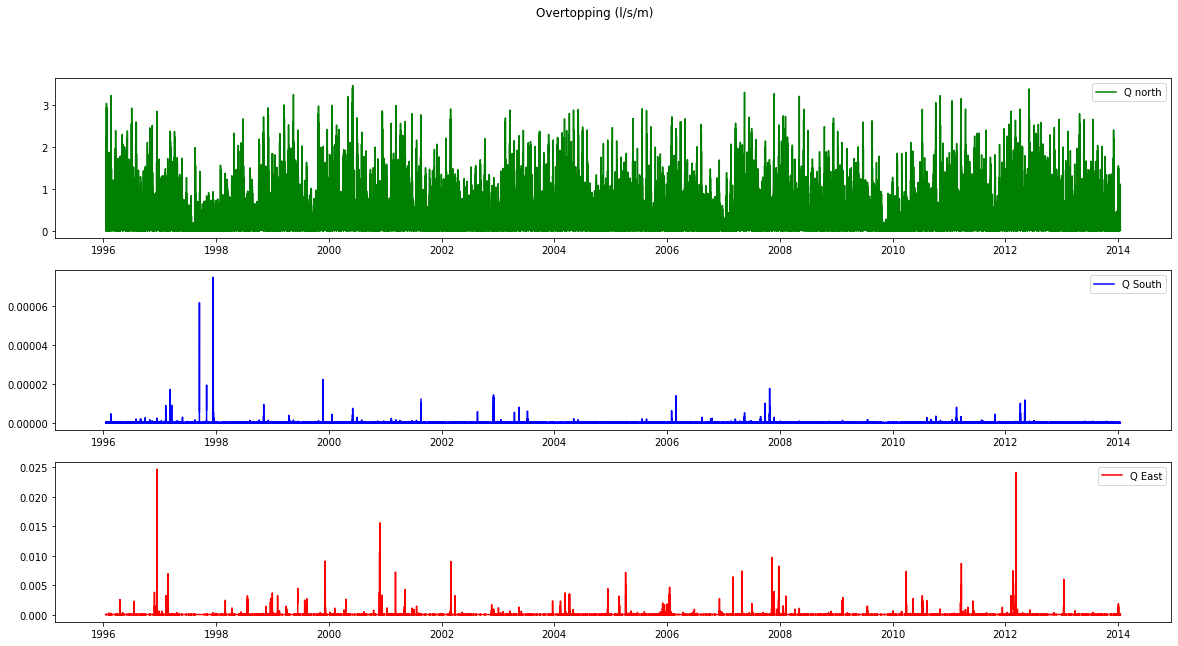

In [14]:
fig, axs = plt.subplots(3,1, figsize=(20,10))

axs[0].plot(out_sim_N.time, out_sim_N.Qinv, color='g', label='Q north')
axs[1].plot(out_sim_S.time, out_sim_S.Qinv, color='b', label='Q South')
axs[2].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.suptitle('Overtopping (l/s/m)')

sys.exit()


fig, axs = plt.subplots(3,1, figsize=(20,10))

axs[0].plot(out_sim_N.time, out_sim_N.Q, label='Q north')
axs[1].plot(out_sim_S.time, out_sim_S.Q, label='Q South')
axs[2].plot(out_sim_E.time, out_sim_E.Q, label='Q East')

plt.suptitle('Overtopping (l/s/m)')

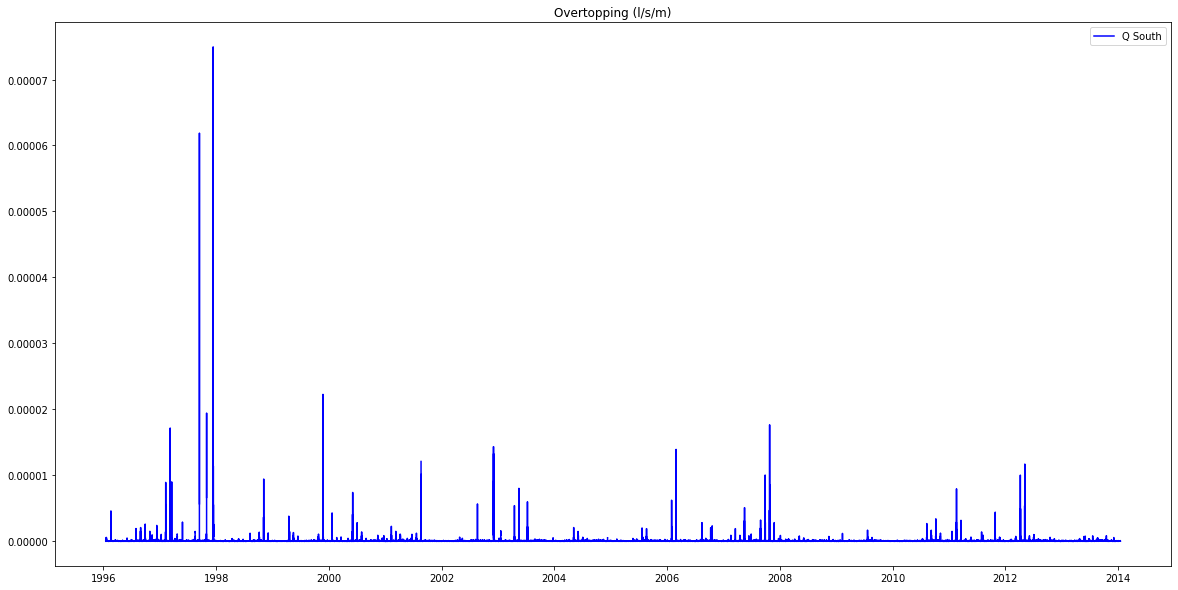

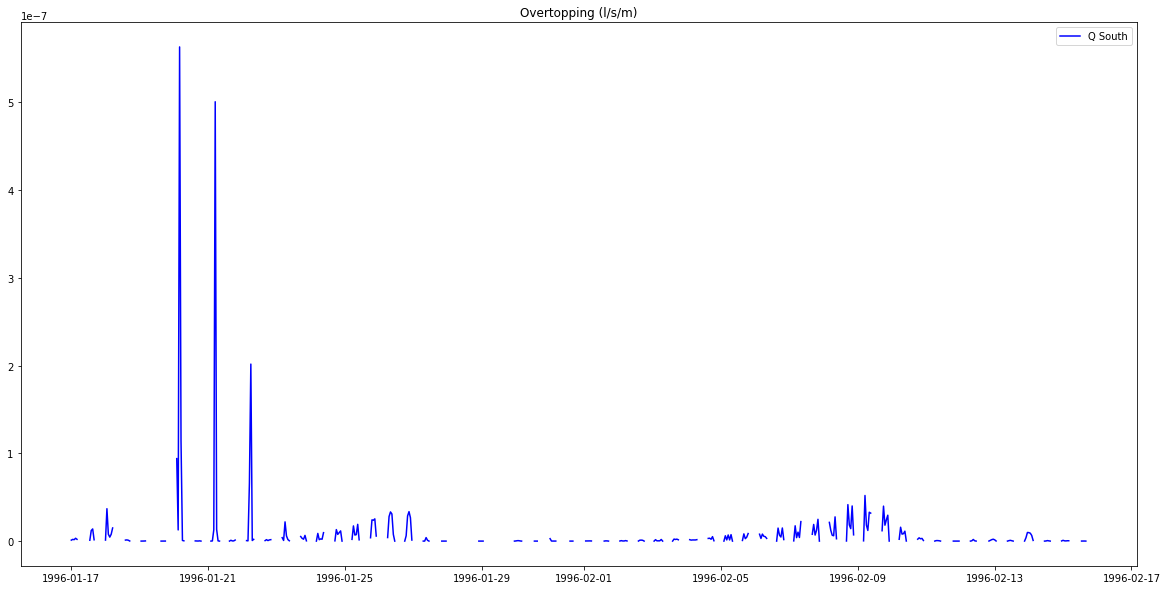

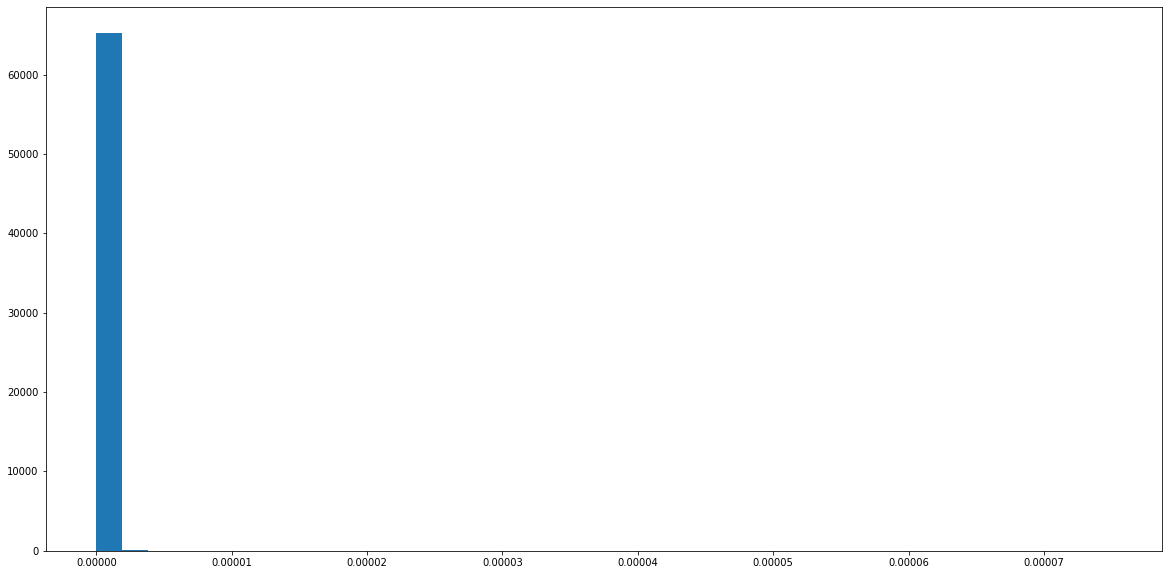

[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100. ]

[8.92825798e-33 5.21482042e-15 1.35976889e-13 9.64951338e-13
 3.92741189e-12 1.11635381e-11 2.54657942e-11 5.12955569e-11
 9.38705666e-11 1.54954468e-10 2.44912861e-10 3.58689256e-10
 5.15857569e-10 7.04349955e-10 9.42533605e-10 1.24459136e-09
 1.59994327e-09 2.03213748e-09 2.57923329e-09 3.21789411e-09
 3.97334122e-09 4.88685777e-09 5.96911277e-09 7.29820425e-09
 8.79117979e-09 1.05615731e-08 1.26200125e-08 1.50464633e-08
 1.70888359e-08 1.97099942e-08 2.29977782e-08 2.68980398e-08
 3.17175537e-08 3.76545925e-08 4.49476640e-08 5.38465063e-08
 6.39593841e-08 7.52837428e-08 8.61419716e-08 9.33618979e-08
 7.49427389e-05]


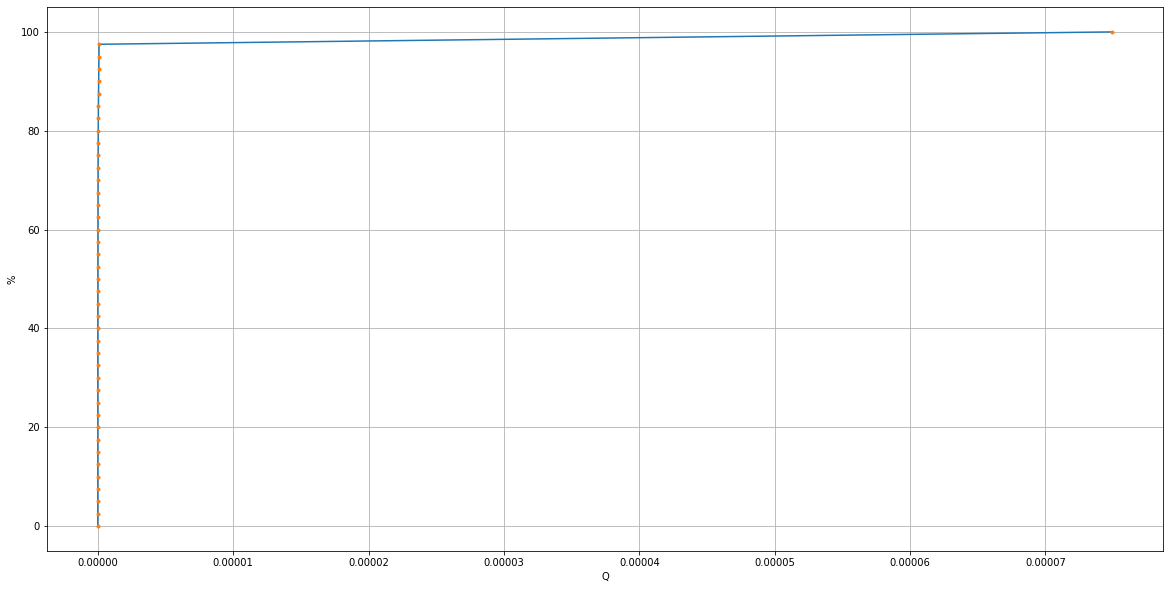

In [15]:
plt.figure(figsize=(20,10))

plt.plot(out_sim_S.time, out_sim_S.Qinv, color='b', label='Q South')
plt.legend()
plt.legend()
plt.title('Overtopping (l/s/m)')


plt.figure(figsize=(20,10))

plt.plot(out_sim_S.time.values[0:24*30], out_sim_S.Qinv.values[0:24*30], color='b', label='Q South')
plt.legend()
plt.legend()
plt.title('Overtopping (l/s/m)')


# histogram
plt.figure(figsize=(20,10))
bins_number = 40 
bins = np.linspace(np.nanmin(out_sim_S.Qinv.values), np.nanmax(out_sim_S.Qinv.values), bins_number)

n, _, _ = plt.hist(out_sim_S.Qinv.values, bins)
plt.show()


# percentiles
q = np.linspace(0,100,41)
perc = np.nanpercentile(out_sim_S.Qinv.values, q)

plt.figure(figsize=(20,10))
plt.plot(perc, q)
plt.plot(perc, q, '.')
plt.xlabel('Q')
plt.ylabel('%')
plt.grid()

print(q)
print()
print(perc)